In [80]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

In [3]:
def _zero_out_utrs(y):
    # copied from HelixerSequence due to an import error
    y[..., 0] = np.logical_or(y[..., 0], y[..., 1])
    y[..., 1] = 0

In [4]:
def cross_entropy(y_true, y_pred):
    true_class_preds = y_pred[y_true.astype(np.bool)]
    losses = -np.log(true_class_preds)
    return losses

In [5]:
def dna_sequence(y):
    letters = 'CATG'
    sequence = ''.join([letters[idx] for idx in np.nonzero(y)[1]])
    return sequence

In [6]:
f = h5py.File('/home/felix/git/HelixerPrep/data/plants/nine_genomes_nosplit_tmp/training_data.h5', 'r')
# p = h5py.File('/home/felix/Desktop/x9HyB_Crubella_predictions.h5', 'r')
# d = h5py.File('/home/felix/git/HelixerPrep/data/plants/single_genomes/Crubella/test_data.h5', 'r')

In [7]:
X = f['data/X']
y_true = f['data/y']
y_pred = f['data/predictions']
sw = f['data/sample_weights']
seqids = f['data/seqids'][:]
species = f['data/species'][:]
start_ends = f['data/start_ends'][:]
print(f'{X.shape=}, {y_true.shape=}, {y_pred.shape=}, {sw.shape=}')

X.shape=(413641, 20000, 4), y_true.shape=(413641, 20000, 4), y_pred.shape=(1, 413641, 20000, 4), sw.shape=(413641, 20000)


In [58]:
losses = np.zeros(y_true.shape[0], dtype=np.float32)
frac_sw = np.zeros(y_true.shape[0], dtype=np.float32)  # fraction of sample weights in non-padding regions
chunk_size = 10000
for offset in range(0, y_true.shape[0], chunk_size):
    chunk_slice = slice(offset, offset + chunk_size)
    y_true_chunk, y_pred_chunk, sw_chunk = y_true[chunk_slice], y_pred[0, chunk_slice], sw[chunk_slice]
    
    # remove utr column
    _zero_out_utrs(y_true_chunk)
    y_true_chunk = np.delete(y_true_chunk, 1, axis=-1)
    y_pred_chunk = np.delete(y_pred_chunk, 1, axis=-1)
    
    # calculate losses for each sample individually due to padding
    # sample weights are not taken into account
    for i in range(chunk_size):
        y_true_sample, y_pred_sample, sw_sample = y_true_chunk[i], y_pred_chunk[i], sw_chunk[i]
        losses[offset + i] = np.mean(cross_entropy(y_true_sample, y_pred_sample))
        n_genetic_bases = np.count_nonzero(y_true_sample)
        frac_sw[offset + i] = 1 - (np.count_nonzero(sw_sample) / n_genetic_bases)
        print(n_genetic_bases)
        
    print(f'calculated losses for offset {offset + chunk_size} / {y_true.shape[0]}')

calculated losses for offset 10000 / 413641


In [81]:
# sample weight color map
cmap = colors.ListedColormap(['red', 'white'])
bounds=[0, 0.5, 1.0]
norm = colors.BoundaryNorm(bounds, cmap.N)

<AxesSubplot:>

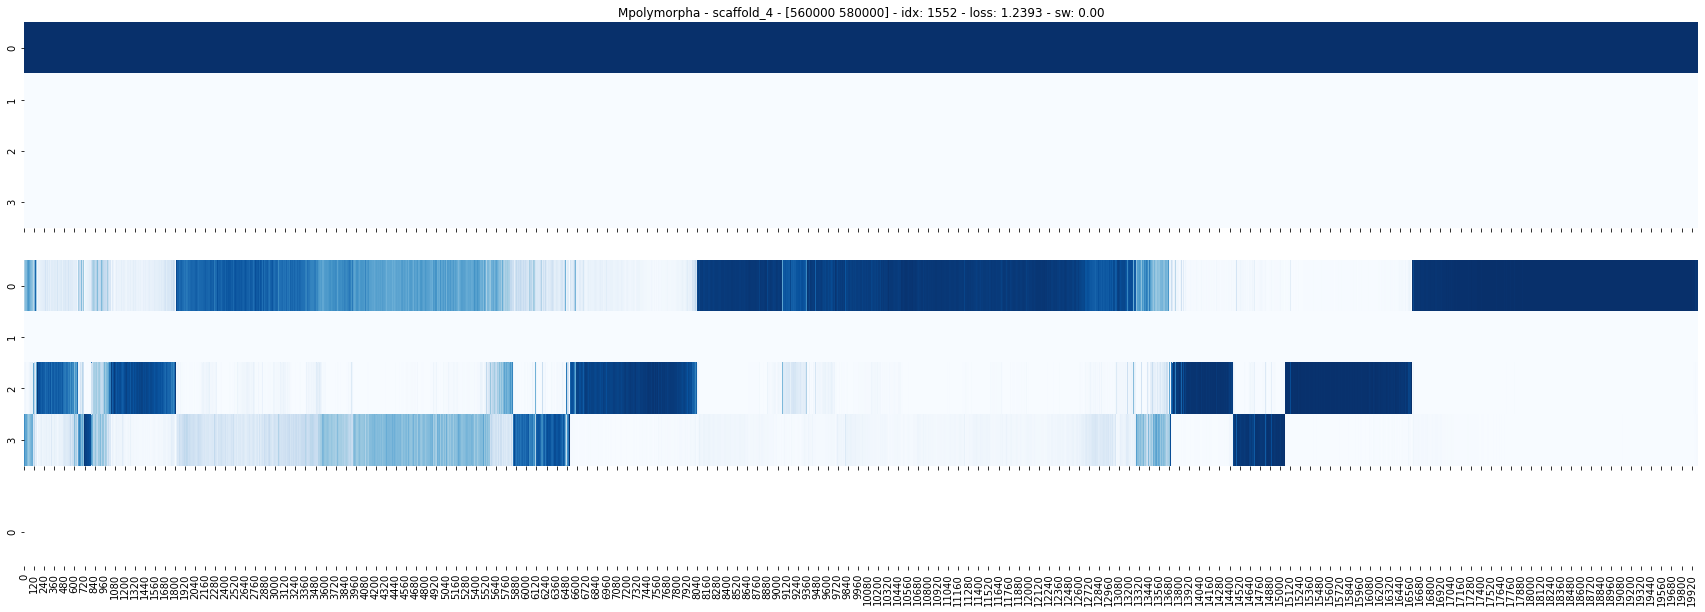

In [86]:
idx = loss_idx[-(np.random.randint(100 + 1))]  # choose sample from the 1000 with the highest loss
# idx = 591
fig, axes = plt.subplots(3, figsize=(30, 10), sharex=True, gridspec_kw={'height_ratios': [3, 3, 1]})
axes[0].set_title(f'{species[idx].decode()} - {seqids[idx].decode()} - {start_ends[idx]} - idx: {idx} - loss: {losses[idx]:.4f} - sw: {frac_sw[idx]:.2f}')
sns.heatmap(y_true[idx].T, cbar=False, cmap='Blues', ax=axes[0])
sns.heatmap(y_pred[0, idx].T, cbar=False, cmap='Blues', ax=axes[1])
sns.heatmap(sw[idx][:, None].T, cbar=False, cmap=cmap, norm=norm, ax=axes[2])

In [33]:
dna_sequence(X[idx][4200:7000])

'GCTGAGAAAGGTCATAAAATCACTTTTTTGCTCCCCAATAAATCCCAAAAGCAACTTGAGCTACCTCTATAGCTCACGACCTTATCCCTGGTGGTGAACTAGGAGTTCCTCCACATGGTTATCCTTCATCAAAGGCGTTGTATCGCAAAAACGATGCTCATGCCTTGTTGATCTTCTCTAGTTTTTACAAGACGTTTTATCATAGGCTCATGATATATCATGGTTTTTACGGGTTTTTGGCCATGATATAAGTCTTATTTATAGAGATTTTATAGTGTTTTCGAGTCTTTTGCAGTCATTTCAGGATTAGGAGCTATTTGGCATGGATTGAAGCTTTTGGAGCATTTGGGAGCATTTGGAGAAGATGTGCCGAAGGAACGTACCGGGAGAGCATATTTGGTGTGAGGGTCGAGCGTCACAACCTATGGTGTCGATCGACACCAATATCTGACGGCAATTGAATTTCTCGATTAATTGAAGTTCAGAAGATTTGTAGATTCGGCCCAGAAGTTTCCCTTATTTACAATTAAGTCCAGTTCGTGGTTAAGACATATATATTGAGTTTTAGGGTTTTGTTAAGACTTAAGCTTTATTTTAGAGAGAGAGAGATTTGTAGAGAGCCAGGAGAGAAGAATCCAAACCTCTTTCAGAGAAGATTCAGAACTCCTTTACTTCTTCTATTACTTTCTTTTATGATATCTATTTTATTCATGATGTTTGTTTCATTCACCATGTTTGAGTAGATTTCTTGTTAGGTTTAGGGTTTTCAAAGGAATTTATGAATTGTTAGGTTGTTAGATTGTTAGGATTGAATCAATAGAGTTCTTCATCTAGATTGTGGTTAATTTGTTCTAGAGTAGTGAAAGCAACCTAGAATATGATCTTAGGTTAATTGGTAGACACGAAAGTGTTATTGATTTCCTGAAAATAATCTAGATGAGCAAAATTCCTATTCGCAAAGAGATTTGGTTTAGGGATTTTGTGAACTTATCAAACCTG